# TEF Budget

Demonstration of accurate velocity and salinity extraction for a control volume defined by one or more sections.

Performs water and salt balances, calculating the imbalance (error) and plotting it on a time series. Tidal averaging will reduce the apparent magnitude of the errors by removing the tidal component. Some of this error is irrelevant to the TEF extraction, and is introduced from interpolating $dV/dt$ on a 1-hour interval. I have found that the error reduces quite a bit, from ~60% to 20% of $Q_R$, when a separate hydrodynamic run is made with a 1/2-hour output interval. Velocity extractions must be done against an identical run with the standard 1-hour output interval. The code in this notebook is smart enough to handle the difference in output frequency between the two sets of NetCDF files.

In [1]:
hydro_output_cdf = '/net/babaracus/home/benr/wqmodels/ssm/hifreq-hydro-test/OUTPUT/netcdf/ssm_*.nc'
hydro_output_start = '2014-01-01'
rivers_cdf = '../input_files/data/fvcom_riv_2014.nc'
extracts_path = '/home/benr/wqmodels/lo/LiveOcean_output/tef/union1x_test'
section_names = ['HoodCanalEntrance']

tide_avg = False

import os.path as path
from multiprocessing import Pool

from netCDF4 import Dataset, MFDataset
import networkx as nx
import numpy as np
from scipy.interpolate import interp1d
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
from fvcom.grid import FvcomGrid
if tide_avg:
    # From LiveOcean; add LiveOcean/alpha to conda.pth
    from zfun import filt_godin

In [2]:
hydro_output = MFDataset(hydro_output_cdf)
hydro_output

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: FVCOM Velocity Blockage Test(Updated Block with Kelp June 2013)                 
    institution: School for Marine Science and Technology
    source: FVCOM_2.7
    history: model started at: 28/11/2022   12:46
    references: http://fvcom.smast.umassd.edu
    Conventions: CF-1.0
    dimensions = ('scalar', 'node', 'nele', 'siglay', 'siglev', 'three', 'four', 'obc', 'obc2', 'time')
    variables = ('nprocs', 'partition', 'Initial_Density', 'x', 'y', 'lon', 'lat', 'siglay', 'siglay_shift', 'siglev', 'h', 'nv', 'a1u', 'a2u', 'aw0', 'awx', 'awy', 'time', 'iint', 'u', 'v', 'ww', 'wts', 'uard_obcn', 'xflux_obc', 'dtfa', 'kh', 'zeta', 'salinity', 'temp')
    groups = ()

In [3]:
section_files = {}
section_extractions = {}
for s in section_names:
    f = path.join(extracts_path, 'extractions/' + s + '.nc')
    section_files[s] = f
    section_extractions[s] = Dataset(f)
    display(section_extractions[s])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    gtagex: union1x_test
    date_string0: 2014.01.01
    date_string1: 2014.12.31
    dimensions(sizes): xi_sect(6), s_z(10), ocean_time(8736), sdir_str(2), xy(2)
    variables(dimensions): float64 ocean_time(ocean_time), float64 salt(ocean_time, s_z, xi_sect), float64 q(ocean_time, s_z, xi_sect), float64 z0(s_z, xi_sect), float64 DA0(s_z, xi_sect), float64 lon(xi_sect), float64 lat(xi_sect), float64 h(xi_sect), int64 ele(xi_sect), float64 zeta(ocean_time, xi_sect), float64 n(xi_sect, xy)
    groups: 

In [4]:
grid = FvcomGrid.from_output(hydro_output)
grid

FvcomGrid(ncoord=array([[4.1320981e+05, 4.0058141e+05, 3.9043006e+05, ..., 4.9810700e+05,
        4.9905700e+05, 4.9871100e+05],
       [4.9160915e+06, 4.9165735e+06, 4.9164565e+06, ..., 5.2337970e+06,
        5.2338140e+06, 5.2341420e+06],
       [1.0275730e+02, 1.6055827e+02, 1.6055827e+02, ..., 4.0000000e+00,
        4.0000000e+00, 4.0000000e+00]], dtype=float32), nv=masked_array(
  data=[[   88,    88,     2, ..., 16008, 16009, 16009],
        [   89,     1,    90, ..., 16009, 16012, 16010],
        [    1,     2,    88, ..., 16011, 16011, 16012]],
  mask=False,
  fill_value=999999), calc=True)

# Define the Control Volume

First, identify all of the nodes adjacent to the section elements on the upstream and downstream sides.

If you're trying to understand this code I strongly recommend looking at it alongside a section plot.

In [5]:
def get_section_nodes(f):
    s = Dataset(f)
    upstream_nodes = set()
    downstream_nodes = set()
    for ele,n,prev in zip(s['ele'], s['n'][:,:], np.concatenate(([0], s['ele'][:-1]))):
        if prev == 0:
            # Find the two nodes along the starting edge
            nodes = grid.nv[grid.nbe[:,ele-1].nonzero()[0], ele-1]
        else:
            # Find the nodes shared with the previous element
            which_prev_nei = (grid.nbe[:, prev - 1] == ele).nonzero()[0]
            non_nei_idxs = (np.arange(3) != which_prev_nei).nonzero()[0]
            nodes = grid.nv[non_nei_idxs, prev - 1]
        midpoint = np.mean(grid.ncoord[:2, nodes-1], axis=1)
        # Construct a vector from the element centroid to the shared/edge midpoint
        center = grid.elcoord[:2, ele-1]
        a = midpoint - center
        # Project the midpoint coordinates onto the a/n coordinate system centered on
        # the element centroid.
        A = np.array([a, n]).T
        Ainv = np.linalg.inv(A)
        nodes_recenter = grid.ncoord[:2, nodes-1] - np.broadcast_to(center, (2,2)).T
        nodes_xform = Ainv @ nodes_recenter
        # The normal vector "n" points in the up-estuary direction. So the
        # node coordinate transformed into the (a,n) vector space will have a
        # positive n component if the node is on the upstream side.
        upstream_nodes |= set(nodes[np.nonzero(nodes_xform[1] > 0)[0]])
        downstream_nodes |= set(nodes[np.nonzero(nodes_xform[1] < 0)[0]])
    # Find the other edge node of the last element
    nodes = grid.nv[grid.nbe[:,s['ele'][-1]-1].nonzero()[0], s['ele'][-1]-1]
    s.close()
    # One of the edge nodes has been added to either upstream_nodes or
    # downstream_nodes. Add the other one to the other set
    if nodes[0] in upstream_nodes:
        downstream_nodes.add(nodes[1])
    elif nodes[0] in downstream_nodes:
        upstream_nodes.add(nodes[1])
    elif nodes[1] in upstream_nodes:
        downstream_nodes.add(nodes[0])
    elif nodes[1] in downstream_nodes:
        upstream_nodes.add(nodes[0])
    return (upstream_nodes, downstream_nodes)

#with Pool() as pool:
#    border_nodes = dict(zip(section_files.keys(),
#                        pool.map(get_section_nodes, section_files.values())))
border_nodes = {k: get_section_nodes(v) for k, v in section_files.items()}
border_nodes

{'HoodCanalEntrance': ({7161, 7162, 7163, 7164}, {7081, 7082, 7083, 7084})}

Get the grid's node adjacency, then remove all connections between upstream and
downstream nodes on all sections. If calculations were done correctly, this will
break up the graph created in the next cell into separate components, one of which
will be our control volume

In [6]:
adj_dict = grid.node_neis()
# 
for s, (upstream_nodes, downstream_nodes) in border_nodes.items():
    for un in upstream_nodes:
        adj_dict[un] -= downstream_nodes
    for dn in downstream_nodes:
        adj_dict[dn] -= upstream_nodes

In [7]:
g = nx.Graph(adj_dict)
#assert len(list(nx.articulation_points(g))) == 0

Use the graph to find which component is our control volume, based on all sections having nodes within it.

In [8]:
if len(border_nodes) == 1:
    # Just pick an upstream node
    node = list(upstream_nodes)[0]
else:
    first_section = next(iter(border_nodes))
    candidates = [list(bns)[0] for bns in border_nodes[first_section]]
    node = None
    # We need to test every other section to handle sections that end at islands.
    # It's then possible for mirror sides of two sections to connect to each other.
    for other_section,nodes in border_nodes.items():
        if other_section == first_section:
            continue
        tests = [list(bns)[0] for bns in border_nodes[other_section]]
        if not nx.has_path(g, candidates[0], tests[0]) and not nx.has_path(
            g, candidates[0], tests[1]):
            node = candidates[1]
            break
    else:
        node = candidates[0]
cv_nodes = nx.node_connected_component(g, node)
cv_node_list = np.array(list(cv_nodes))
len(cv_nodes)
#cv_node_list

729

# Volume Balance

## Get CV Volume Change

Calculate all node volumes in the CV (TCE area times depth plus surface el), then differentiate with time

In [9]:
node_tces = grid.tces_gdf()
node_tces.head()

,geometry
1,"POLYGON ((413506.938 4920788.000, 410871.844 4..."
2,"POLYGON ((395505.750 4916515.000, 400581.406 4..."
3,"POLYGON ((395505.750 4916515.000, 395667.781 4..."
4,"POLYGON ((385530.031 4917393.000, 385541.844 4..."
5,"POLYGON ((378155.000 4921735.000, 380625.156 4..."


In [10]:
node_areas = node_tces.loc[cv_node_list, 'geometry'].area.to_numpy()
# V neglects the constant depth addend to avoid rounding errors. It doesn't
# affect the derivative
zetas = hydro_output['zeta'][:,cv_node_list-1]
V = (node_areas * zetas).sum(axis=1)
display(V.shape)
V

(17568,)

array([-8.26438710e+07, -1.88340004e+08, -2.72151165e+08, ...,
       -4.43102712e+07,  1.03617365e+08,  2.57127143e+08])

In [11]:
# This simple method is not accurate enough. It's a lagged difference
# that introduces errors on a tidal frequency
# See https://stackoverflow.com/a/18993405
#dVdt = np.diff(V) / np.diff(hydro_output['time'][:])
dVdt = ndimage.gaussian_filter1d(V, sigma=1, order=1)[1:] / np.diff(hydro_output['time'][:])
display(dVdt.shape)
dVdt

(17567,)

array([-41759.95570862, -40586.87004137, -37403.96806047, ...,
        78067.80954968,  70197.19193728,  30583.6035919 ])

## Tidal transport in and out of section (Q_prism)

In [12]:
q_in = {}
q_out = {}
for s, ds in section_extractions.items():
    upstream_nodes, downstream_nodes = border_nodes[s]
    # Figure out if the control volume is on the upstream or downstream side.
    # This will determine the direction of the transport variable relative to
    # the CV.
    test_node = list(upstream_nodes)[0]
    cv_node = cv_node_list[-1]
    direction = 1 if nx.has_path(g, cv_node, test_node) else -1
    # shape becomes (s_z, xi_sect, time)
    q = np.moveaxis(ds['q'][:], 0, 2)
    # shape becomes (xi_sect, time)
    q_in[s] = (np.where(q * direction > 0, q, 0) * direction).sum(axis=(0,1))
    q_out[s] = (np.where(q * direction < 0, q, 0) * direction).sum(axis=(0,1))
    display(f'q_prism,in {s}', q_in[s])
    display(f'q_prism,out {s}', q_out[s])

'q_prism,in HoodCanalEntrance'

array([    0.        ,  2048.39140536,  4246.94299301, ...,
       67874.48777688, 73149.79866114, 59187.48629318])

'q_prism,out HoodCanalEntrance'

array([-5.24691165e+04, -2.28270526e+04, -1.15634295e+04, ...,
       -4.95804121e+01, -2.10928674e+01, -6.42294946e+01])

## Get River Discharges into CV

Rivers discharge into nodes that are listed in `cv_nodes`. Discharges must be interpolated to the output frequency of the model.

In [13]:
rivers = Dataset(rivers_cdf)
rivers

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    inflow_type: node
    point_st_type: calculated
    dimensions(sizes): time(365), node(201), siglay(10)
    variables(dimensions): float32 time(time), int32 node(node), float32 vqdist(node, siglay), float32 discharge(time, node), float32 temp(time, node), float32 salt(time, node)
    groups: 

In [14]:
rivers_in_cv = set(rivers['node'][:]) & cv_nodes
rivers_in_cv

{7853,
 7854,
 8554,
 9784,
 11205,
 11206,
 11591,
 11592,
 11601,
 11602,
 11867,
 12872,
 12873,
 13626,
 13833,
 13834,
 14138,
 14139,
 14211,
 14235}

(365,)

[Text(0, 0.5, 'Flow ($m^3/s$)'), Text(0.5, 0, 'Year Day')]

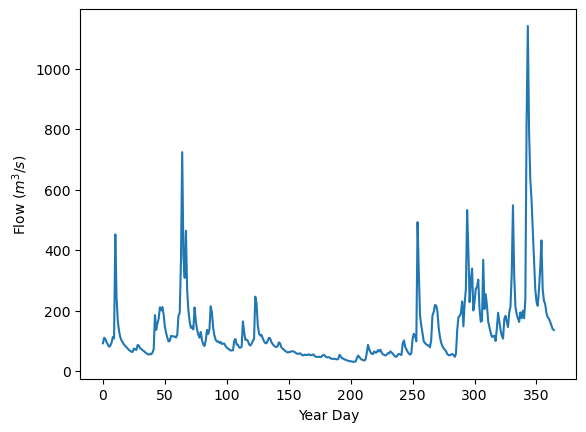

In [15]:
if len(rivers_in_cv) == 0:
    river_qs = np.zeros_like(rivers['time'][:])
else:
    rivers_idxs = np.where(np.isin(np.ma.getdata(rivers['node'][:]),
                                   list(rivers_in_cv)))[0]
    river_qs = rivers['discharge'][:,rivers_idxs].sum(axis=1)
display(river_qs.shape)
fig, ax = plt.subplots()
ax.plot(rivers['time'][:] / 24, river_qs)
ax.set(ylabel='Flow ($m^3/s$)', xlabel='Year Day')

In [16]:
onesect = next(iter(section_names))

# model output times are in seconds
# Get times from a section extraction since they are at a guaranteed 1-hr frequency
section_dates = pd.Timestamp('1970-01-01') + pd.to_timedelta(section_extractions[onesect]['ocean_time'][:], 's')
# Convert dates back to seconds since the start of the model run
section_output_times = ((section_dates - pd.Timestamp(section_extractions[onesect].date_string0)) /
                      np.timedelta64(1, 's')).astype(int).to_numpy()
# The output times from the model run may be at a higher frequency, but there should be overlap
model_output_times = hydro_output['time'][:]
# river times are in hours; convert them
river_times = rivers['time'][:] * 3600
# The model can potentially run past the boundary conditions, and if that
# happened we need to truncate the output
cut_indices_model = (model_output_times > river_times.max()).nonzero()[0]
if len(cut_indices_model) > 0:
    time_removed_model = (model_output_times[cut_indices_model.max()] -
                          model_output_times[cut_indices_model.min()]) / 87600
    print(f'Need to remove {time_removed_model:.2f} days of model output from end of run')
    right_cut_model = cut_indices_model.min()
    model_output_times = model_output_times[:right_cut_model]
else:
    right_cut_model = None
cut_indices_section = (section_output_times > river_times.max()).nonzero()[0]
if len(cut_indices_section) > 0:
    right_cut_section = cut_indices_section.min()
    section_output_times = section_output_times[:right_cut_section]
    section_dates = section_dates[:right_cut_section]
else:
    right_cut_section = None
rivers_interp = interp1d(river_times, river_qs)(section_output_times)

Need to remove 1.95 days of model output from end of run


## Perform Volume Balance and Plot Result

In [17]:
if tide_avg:
    dVdt = filt_godin(dVdt)
    dVdt_section = filt_godin(dVdt_section)
    rivers_interp = filt_godin(rivers_interp)
    for s in section_names:
        q_in[s] = filt_godin(q_in[s])
        q_out[s] = filt_godin(q_out[s])

In [18]:
model_dates = pd.Timestamp(hydro_output_start) + pd.to_timedelta(model_output_times[1:], 's')
model_df = pd.DataFrame({'$dV/dt$': dVdt[:right_cut_model-1]}, index=model_dates)
section_data = {}
for x in section_names:
    section_data[x + ' $Q_\mathrm{prism,in}$'] = q_in[x]
    section_data[x + ' $Q_\mathrm{prism,out}$'] = q_out[x]
section_data['$Q_R$'] = rivers_interp
vol_budget = model_df.merge(pd.DataFrame(section_data, index=section_dates), how='left', left_index=True, right_index=True)
vol_budget['error'] = -vol_budget['$dV/dt$'] + vol_budget[vol_budget.columns[vol_budget.columns != '$dV/dt$']].sum(1)
vol_budget.loc[vol_budget['$Q_R$'].isna(), 'error'] = np.nan
vol_budget.tail()

,$dV/dt$,"HoodCanalEntrance $Q_\mathrm{prism,in}$","HoodCanalEntrance $Q_\mathrm{prism,out}$",$Q_R$,error
2014-12-30 22:00:00,68338.765877,67874.487777,-49.580412,135.910887,-377.947625
2014-12-30 22:30:00,70636.353272,NaN,NaN,NaN,NaN
2014-12-30 23:00:00,70792.918766,73149.798661,-21.092867,135.758346,2471.545374
2014-12-30 23:30:00,66493.847316,NaN,NaN,NaN,NaN
2014-12-31 00:00:00,56673.578300,59187.486293,-64.229495,135.605804,2585.284303


Error:          1.36 cms (1.02% of mean Q_R)
Error per dVdt: 19.38%
RMSE:           25.37 cms (19.08% of mean Q_R)


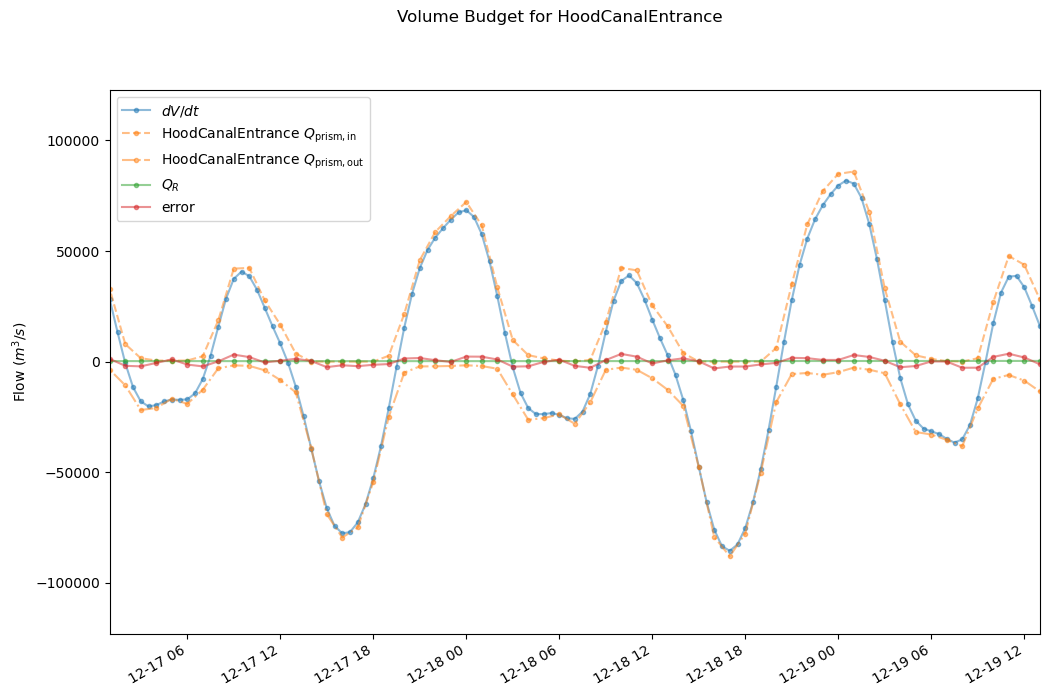

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
l = None
for c in vol_budget.columns:
    color = None
    if c[-5:-2] == 'out':
        color = l[0].get_color()
        linestyle = '.-.'
    elif c[-4:-2] == 'in':
        linestyle = '.--'
    else:
        linestyle = '.-'
    l = ax.plot(vol_budget[c].dropna(), linestyle, color=color, label=c, alpha=0.5)

if not tide_avg:
    qr = vol_budget['$Q_R$'].dropna()
    ax.set(xbound=(qr.index[8400], qr.index[8460]))
ax.set(ylabel="Flow ($m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'Volume Budget for {", ".join(section_names)}')

# Fudge factor to get the tide cycle right on mean error
fudge = 83
error = vol_budget[['$dV/dt$','$Q_R$','error']].dropna()
mean_error = error['error'][fudge:].mean()
error_per_qr = np.nan if error['$Q_R$'].mean() == 0 else mean_error / error['$Q_R$'].mean()
error_per_dVdt = np.abs(mean_error / error['$dV/dt$'][fudge:].mean())
rmse = np.sqrt((error['error'] ** 2).sum())/len(error['error'])
rmse_per_qr = np.nan if error['$Q_R$'].mean() == 0 else rmse / error['$Q_R$'].mean()
print(f'Error:          {mean_error:.2f} cms ({error_per_qr * 100:.2f}% of mean Q_R)')
print(f'Error per dVdt: {error_per_dVdt*100:.2f}%')
print(f'RMSE:           {rmse:.2f} cms ({rmse_per_qr * 100:.2f}% of mean Q_R)')

# Salt Balance

## Calculate d(VS)/dt

First get the total volume broken down by node, layer, and time index

In [20]:
hydro_output['siglev'].set_auto_mask(False)
total_vol = node_areas * (
    np.expand_dims(hydro_output['siglev'][:-1] - hydro_output['siglev'][1:], 1
                  ) @ np.expand_dims(hydro_output['h'][cv_node_list-1], 0))
# Adjust for tides
siglay_ct = hydro_output.dimensions['siglay'].size
total_vol = total_vol * (1 + np.swapaxes(np.broadcast_to(
    zetas / hydro_output['h'][cv_node_list-1],
    (siglay_ct, zetas.shape[0], zetas.shape[1])
), 0, 1))
total_vol.shape

(17568, 10, 729)

In [21]:
VS = (hydro_output['salinity'][:,:,cv_node_list-1] * total_vol).sum(axis=(1,2))
VS.shape

(17568,)

In [22]:
dVSdt = ndimage.gaussian_filter1d(VS, sigma=1, order=1)[1:] / np.diff(hydro_output['time'][:])
display(dVSdt.shape)
dVSdt

(17567,)

array([-1244703.60704891, -1208483.38112331, -1113344.22660516, ...,
        2299114.8962926 ,  2067719.85684311,   901174.39593375])

## Calculate salinity fluxes in and out

In [23]:
qs_in = {}
qs_out = {}
for s, ds in section_extractions.items():
    upstream_nodes, downstream_nodes = border_nodes[s]
    # Figure out if the control volume is on the upstream or downstream side.
    # This will determine the direction of the transport variable relative to
    # the CV.
    test_node = list(upstream_nodes)[0]
    cv_node = cv_node_list[-1]
    direction = 1 if nx.has_path(g, cv_node, test_node) else -1
    # shape becomes (s_z, xi_sect, time)
    q = np.moveaxis(ds['q'][:], 0, 2)
    salt = np.moveaxis(ds['salt'][:], 0, 2)
    # shape becomes (xi_sect, time)
    tide_adj = (1 + ds['zeta'][:] / ds['h'][:]).T
    qs_in[s] = (np.where(q * direction > 0, q, 0) * salt * tide_adj * direction).sum(axis=(0,1))
    qs_out[s] = (np.where(q * direction < 0, q, 0) * salt * tide_adj * direction).sum(axis=(0,1))
    display(f'qs_in {s}', qs_in[s])
    display(f'qs_out {s}', qs_out[s])

'qs_in HoodCanalEntrance'

masked_array(data=[0.0, 61329.714414107686, 125798.9108527712, ...,
                   2029926.5935657027, 2211426.2298618583,
                   1807928.8776193568],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

'qs_out HoodCanalEntrance'

masked_array(data=[-1551690.884399748, -668570.9053551895,
                   -336530.48412216094, ..., -1335.9561622683118,
                   -573.7421098277639, -1792.1899824503148],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [24]:
if tide_avg:
    dVSdt = filt_godin(dVSdt)
    dVSdt_section = filt_godin(dVSdt_section)
    for s in section_names:
        qs_in[s] = filt_godin(qs_in[s])
        qs_out[s] = filt_godin(qs_out[s])

## Perform Salt Balance and Plot Result

In [25]:
model_salt_df = pd.DataFrame({'$d(VS)/dt$': dVSdt[:right_cut_model-1]}, index=model_dates)
salt_section_data = {}
for x in section_names:
    salt_section_data[x + ' $QS_\mathrm{prism,in}$'] = qs_in[x]
    salt_section_data[x + ' $QS_\mathrm{prism,out}$'] = qs_out[x]
salt_budget = model_salt_df.merge(pd.DataFrame(salt_section_data, index=section_dates),
                                  how='left', left_index=True, right_index=True)
salt_budget['error'] = -salt_budget['$d(VS)/dt$'] + salt_budget[salt_budget.columns[salt_budget.columns != '$d(VS)/dt$']].sum(1, skipna=False)
salt_budget.tail()

,$d(VS)/dt$,"HoodCanalEntrance $QS_\mathrm{prism,in}$","HoodCanalEntrance $QS_\mathrm{prism,out}$",error
2014-12-30 22:00:00,2.018793e+06,2.029927e+06,-1335.956162,9797.218072
2014-12-30 22:30:00,2.087649e+06,NaN,NaN,NaN
2014-12-30 23:00:00,2.094723e+06,2.211426e+06,-573.742110,116129.730920
2014-12-30 23:30:00,1.969760e+06,NaN,NaN,NaN
2014-12-31 00:00:00,1.678665e+06,1.807929e+06,-1792.189982,127471.622192


Error:             2884.70 psu-cms
Error per d(VS)dt: 1515.74%
RMSE:              1009.31 psu-cms


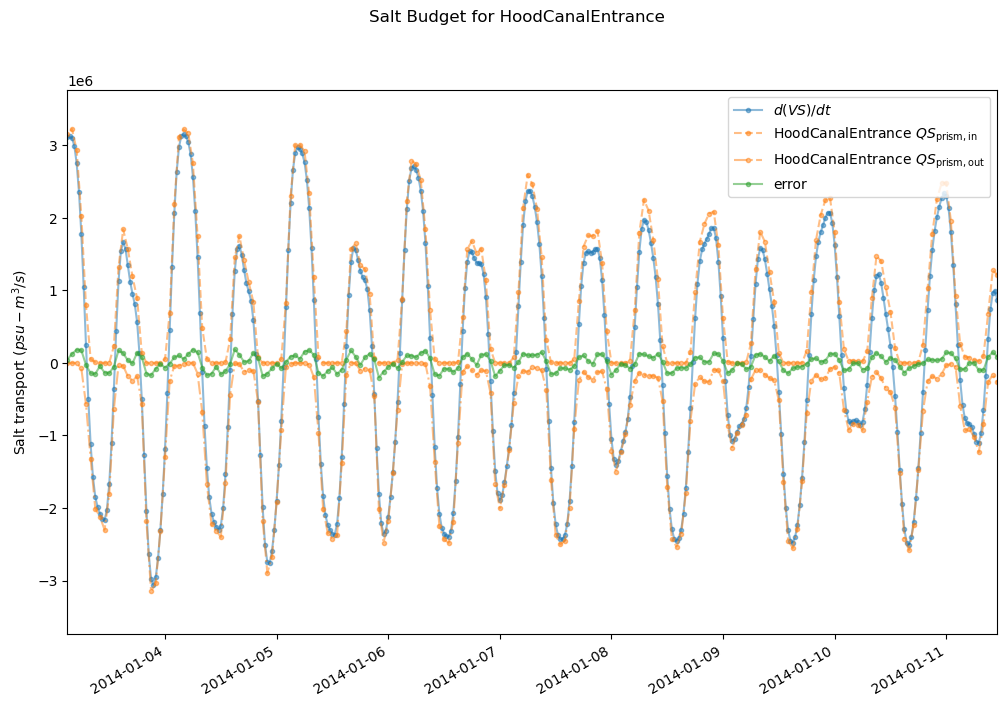

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
l = None
for c in salt_budget.columns:
    color = None
    if c[-5:-2] == 'out':
        color = l[0].get_color()
        linestyle = '.-.'
    elif c[-4:-2] == 'in':
        linestyle = '.--'
    else:
        linestyle = '.-'
    l = ax.plot(salt_budget[c].dropna(), linestyle, color=color, label=c, alpha=0.5)
if not tide_avg:
    ax.set(xbound=(section_dates[50], section_dates[250]))
ax.set(ylabel="Salt transport ($psu-m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'Salt Budget for {", ".join(section_names)}')

salt_error = salt_budget[['$d(VS)/dt$','error']].dropna()[fudge:]
mean_salt_error = salt_error['error'].mean()
error_per_dvsdt = np.abs(mean_salt_error / salt_error['$d(VS)/dt$'][fudge:].mean())
rmse = np.sqrt((salt_error['error'] ** 2).sum())/len(salt_error['error'])

print(f'Error:             {mean_salt_error:.2f} psu-cms')
print(f'Error per d(VS)dt: {error_per_dvsdt*100:.2f}%')
print(f'RMSE:              {rmse:.2f} psu-cms')